# Import des librairies

In [3]:
!pip install fitter
!pip install missingpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fitter: filename=fitter-1.5.1-py3-none-any.whl size=25596 sha256=69432873533be97af532db0b1c4200b1e4bcb9db407a1de1cf03da48d558f1c1
  Stored in directory: /root/.cache/pip/wheels/40/65/62/57b872ba7af36e70111b1f67cffe76f97c747804aff7665ccb
Successfully built fitter
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 2.9 MB/s 


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from fitter import Fitter, get_common_distributions, get_distributions
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.impute import KNNImputer
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Chargement des données

In [6]:
df = pd.read_csv("test_set.csv")

# Prévisualisation

In [ ]:
df

,index,order_requests,city,date,language,mobile,avatar_id,hotel_id,stock
0,0,1,vilnius,21,romanian,0,1,161,46
1,1,1,vilnius,21,romanian,0,1,187,32
2,2,1,vilnius,21,romanian,0,1,279,12
3,3,1,vilnius,21,romanian,0,1,395,10
4,4,1,vilnius,21,romanian,0,1,488,42
...,...,...,...,...,...,...,...,...,...
6639,6639,843,rome,5,irish,0,794,987,1
6640,6640,844,vienna,1,irish,1,794,26,1
6641,6641,844,vienna,1,irish,1,794,263,0
6642,6642,844,vienna,1,irish,1,794,456,0


# Etude des villes

Premièrement nous allons afficher la répartition des villes dans le dataset de test afin de vérifier si elles sont toutes présentes et de manière équitable.

In [ ]:
df["city"].value_counts()

amsterdam     1134
paris         1125
madrid        1094
copenhagen     723
rome           721
vilnius        609
vienna         568
sofia          374
valletta       296
Name: city, dtype: int64

Les villes sont effectivement toutes bien présentes mais de manière très déséquilibrée. Ce déséquilibre pourrait être retrouvé dans l'ensemble des données, ou pas. Pour avoir une idée de la réponse je vais utiliser des métadonnées associées aux villes qui pourraient expliquer le nombre d'hotêls que l'API renvoie pour celles-ci.

Dans un premier temps je vais vérifier si la répartition vue ci-dessus correspond à la taille des villes étudiées (en terme de nombre d'habitants).
Les données sont tirées du site : https://www.populationdata.net/palmares/villes/europe/

In [ ]:
population_data = {"amsterdam" : 2480394, "paris" : 13114718, "madrid" : 6475872, "copenhagen" : 2931445, "rome" : 4340474, "vilnius" : 673921, "vienna" : 2717459, "sofia" : 1681592, "valletta" : 408750}

Ensuite je suis allé extraire le nombre de recherches Google des termes "hotel" plus nom de la ville. J'ai stocké le nombre de résultats de la requête dans une liste (ordre = same que renvoyé par df["city"]).

In [ ]:
nb_url = [258, 705, 328, 69.5, 545, 11.8, 191, 225, 7.47] # unité = 10**6
# chiffres obtenus sur google.com langue = anglais US

J'ai également été sur le site https://www.booking.com/ et récupéré le nombre d'hôtel renvoyé pour une requête dans chaque ville (pas de dates et résa pour 2 adultes).

In [ ]:
data_booking = [1061, 4980, 3344, 475, 9029, 651, 2287, 971, 235]

Des données sur les pays peuvent également être retenues comme le PIB par habitant (à voir si c'est également utilisable pour la feature language).

In [ ]:
PIB = [48424, 38210, 26239, 58586, 31512, 18072, 45091, 8294, 27738]

In [ ]:
l = list(df["city"].value_counts())
df_city = pd.DataFrame(population_data.items(), columns=['city', 'nb_hab'])
df_city["nb_url"] = nb_url
df_city["booking"] = data_booking
df_city["PIB"] = PIB
df_city["nb_val"] = l

In [ ]:
df_city

,city,nb_hab,nb_url,booking,PIB,nb_val
0,amsterdam,2480394,258.00,1061,48424,1134
1,paris,13114718,705.00,4980,38210,1125
2,madrid,6475872,328.00,3344,26239,1094
3,copenhagen,2931445,69.50,475,58586,723
4,rome,4340474,545.00,9029,31512,721
5,vilnius,673921,11.80,651,18072,609
6,vienna,2717459,191.00,2287,45091,568
7,sofia,1681592,225.00,971,8294,374
8,valletta,408750,7.47,235,27738,296


Toutes ces features pourront également être conservées pour aider à l'entraînement de notre modèle plus tard dans le projet.

# Etude de la date

Ici nous allons étudier la distribution des dates dans le jeu de données de test, afin de voir si il y a un pic de réservation et quand se trouve-t-il.

(array([464., 467., 484., 449., 443., 458., 450.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0., 267., 281., 264., 279., 235., 252., 268.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0., 222., 264., 237., 241., 250., 189., 180.]),
 array([ 0.        ,  0.97560976,  1.95121951,  2.92682927,  3.90243902,
         4.87804878,  5.85365854,  6.82926829,  7.80487805,  8.7804878 ,
         9.75609756, 10.73170732, 11.70731707, 12.68292683, 13.65853659,
        14.63414634, 15.6097561 , 16.58536585, 17.56097561, 18.53658537,
        19.51219512, 20.48780488, 21.46341463, 22.43902439, 23.41463415,
        24.3902439 , 25.36585366, 26.34146341, 27.31707317, 28.29268293,
        29.26829268, 30.24390244, 31.2195122 , 32.19512195, 33.17073171,
        34.14634146, 35.12195122, 36.09756098, 37.07317073, 38.04878049,
        39.02439024, 40.        ]),
 <a list of 41 Patch objects>)

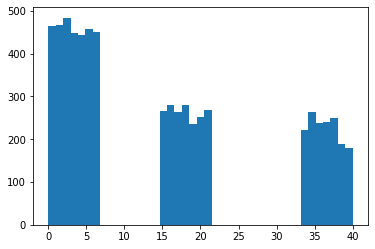

In [ ]:
plt.hist(df["date"], bins= 41) # attention au nombre de bins

En observant la distribution des valeurs il semble clair que celle-ci que des intervalles de dates ont été volontairement retirés du set de test. Nous allons donc tenter d'approximer la distribution de ces valeurs estimant le nombre de réservations à partir de la date dans le but de l'utiliser pour notre stratégie de reqûetage de l'API.

Fitting 5 distributions: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
gamma,0.239915,858.239828,-67934.684545,inf,0.258940,0.000000e+00
burr,0.249705,864.627222,-67660.135711,inf,0.197549,1.106177e-227
beta,0.258416,828.970049,-67432.313491,inf,0.307845,0.000000e+00
lognorm,0.273260,1213.927192,-67070.037150,inf,0.425777,0.000000e+00
norm,0.281189,794.774907,-66888.797458,inf,0.231701,4.208041e-314


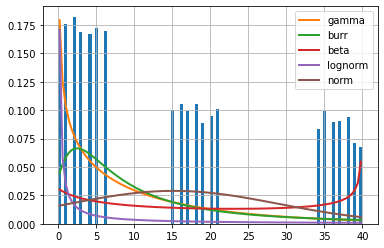

In [ ]:
dates = df["date"].values
f = Fitter(dates, distributions=['gamma', 'lognorm', "beta", "burr", "norm"])
f.fit()
f.summary()

On peut voir ici que les valeurs manquantes nous empêchent de prédire correctement la distribution des données. On va donc tester différentes techniques de data imputation pour régler ce problème.

In [8]:
nb_occ_date = df["date"].value_counts().rename_axis('date').reset_index(name='nb_occ').sort_values(by = ["date"])
# ajout des NaN dans le dataframe
for d in range(0,45):
  if d not in nb_occ_date["date"].values:
    nb_occ_date = nb_occ_date.append({'date':d, 'nb_occ':np.nan}, ignore_index=True)
nb_occ_date = nb_occ_date.sort_values(by = ["date"])

Nous allons effectuer une imputation à l'aide de l'algorithme MissForest.

In [ ]:
# data imputation
imp = MissForest()
nb_occ_date_mf = imp.fit_transform(nb_occ_date)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Iteration: 0


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Iteration: 1


/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Iteration: 2


Affichons maintenant le nombre d'occurrences de chaque date après l'imputation.

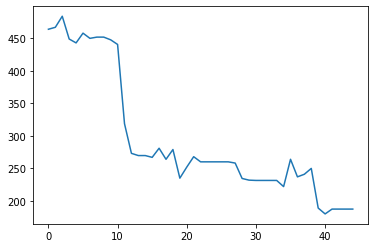

In [ ]:
df_filled_mf = pd.DataFrame(nb_occ_date_mf, columns = ["date", "nb_occ"])
plt.plot(df_filled_mf["date"], df_filled_mf["nb_occ"])

Nous allons maintenant utiliser l'algorithme KNNImputer et comparer les résultats.

In [28]:
imputer = KNNImputer(n_neighbors=8)
nb_occ_date_knn = imputer.fit_transform(nb_occ_date)

In [29]:
df_filled_knn = pd.DataFrame(nb_occ_date_knn, columns = ["date", "nb_occ"])
df_knn = df_filled_knn.copy()
# créer dataframe avec nb_occ fois chaque date
for index, row in df_filled_knn.iterrows():
  for i in range(1, int(row["nb_occ"])): # on commence à 1 car on a déjà 1 fois chaque valeur dans le df
    df_knn = df_knn.append({'date':row["date"], 'nb_occ':row["nb_occ"]}, ignore_index = True)
#plt.plot(df_filled_knn["date"], df_filled_knn["nb_occ"])
df_knn['nb_occ'] = df_knn['nb_occ'].astype(int)

(array([464., 467., 484., 449., 443., 458., 450., 435., 412., 412., 387.,
        334., 310., 287., 287., 267., 281., 264., 279., 235., 252., 268.,
        258., 258., 258., 258., 252., 249., 249., 246., 240., 231., 231.,
        231., 222., 264., 237., 241., 250., 189., 180., 231., 231., 231.,
        231.]),
 array([ 0.        ,  0.97777778,  1.95555556,  2.93333333,  3.91111111,
         4.88888889,  5.86666667,  6.84444444,  7.82222222,  8.8       ,
         9.77777778, 10.75555556, 11.73333333, 12.71111111, 13.68888889,
        14.66666667, 15.64444444, 16.62222222, 17.6       , 18.57777778,
        19.55555556, 20.53333333, 21.51111111, 22.48888889, 23.46666667,
        24.44444444, 25.42222222, 26.4       , 27.37777778, 28.35555556,
        29.33333333, 30.31111111, 31.28888889, 32.26666667, 33.24444444,
        34.22222222, 35.2       , 36.17777778, 37.15555556, 38.13333333,
        39.11111111, 40.08888889, 41.06666667, 42.04444444, 43.02222222,
        44.        ]),
 <a list

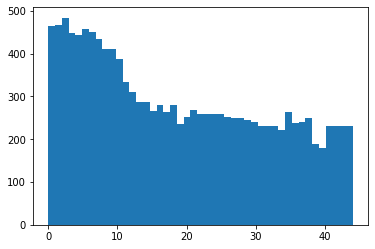

In [30]:
plt.hist(df_knn["date"], bins= 45) # attention au nombre de bins

Les résultats semblent s'approcher bien plus d'une distribution réaliste des valeurs, on va maintenant pouvoir approximer cette distribution de valeurs.

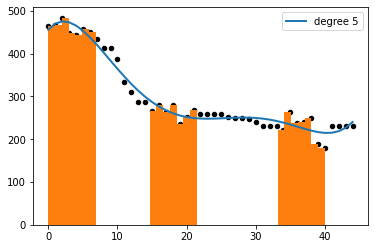

In [33]:
X = df_filled_knn["date"].values.reshape(-1, 1)
y = df_filled_knn["nb_occ"].values.reshape(-1, 1)
models = []
for count, degree in enumerate([5]): # degré à chosir
    model = make_pipeline(PolynomialFeatures(degree), Ridge(alpha=0.001))
    model.fit(X, y)
    models.append(model)
    y_pred = model.predict(X)
    plt.plot(X, y_pred, linewidth=2, label='degree %d' % degree)
plt.legend(loc='upper right')
plt.scatter(X, y, s=20, marker='o', label='training points', c = "black")
plt.hist(df["date"], bins= 41) # attention au nombre de bins
plt.show()

TO DO : Essayer de trouver sur internet un graphe de l'évolution des prix des chambres d'hôtel en fonction de la date de réservation et comparer à ce qu'on a obtenu ici.